In [1]:
%matplotlib inline

In [75]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [76]:
DEVICE_ID = 2
DEVICE = torch.device('cuda:%d' % DEVICE_ID)

torch.cuda.set_device(DEVICE_ID)

In [77]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [7]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [1]:
DATA_PATH  = '/home/v.svinin/04_2/all/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [9]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [10]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [11]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=100,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 40:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 60:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9)
        elif epoch == 80:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/1000, weight_decay=0.0001, momentum=0.9)
        
        #if epoch % 20 == 19:
        #    my_solution = make_solution(a_net, DEVICE)
        #    with open('solution_n{}.csv'.format(epoch), 'w') as fout:
        #        print('Id', 'Prediction', sep=',', file=fout)
        #        for i, prediction in enumerate(my_solution):
        #            print(i, prediction, sep=',', file=fout)
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [12]:
DOWNSAMPLE_COEF = 2

In [13]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        
        if make_downsample: 
            coef = DOWNSAMPLE_COEF
        else: coef = 1
            
        self.a_in_channels = a_in_channels
        self.a_out_channels = a_in_channels * coef
        self.coef = coef
        
        self.conv0 = nn.Conv2d(a_in_channels, self.a_out_channels, kernel_size=1, stride=coef)
        self.conv1 = nn.Conv2d(a_in_channels, self.a_out_channels, kernel_size=3, stride=coef, padding=1)
        self.conv2 = nn.Conv2d(self.a_out_channels, self.a_out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.a_out_channels)
        self.bn2 = nn.BatchNorm2d(self.a_out_channels)
    
    def forward(self, x):
        x_temp = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        if self.use_skip_connection:
            if self.make_downsample:
                x_temp = self.conv0(x_temp)
            return F.relu(x + x_temp)
        return F.relu(x)

In [15]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        self.conv0 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1, bias=False)
        self.features = nn.Sequential()
        self.features.add_module('res_block1_1', CifarResidualBlock(32))
        self.features.add_module('res_block1_2', CifarResidualBlock(32))
        self.features.add_module('res_block1_3', CifarResidualBlock(32, make_downsample = True))
        self.features.add_module('res_block2_1', CifarResidualBlock(64))
        self.features.add_module('res_block2_2', CifarResidualBlock(64))
        self.features.add_module('res_block2_3', CifarResidualBlock(64, make_downsample = True))
        self.features.add_module('res_block3_1', CifarResidualBlock(128))
        self.features.add_module('res_block3_2', CifarResidualBlock(128))
        self.features.add_module('res_block3_3', CifarResidualBlock(128, make_downsample = True))
        self.features.add_module('res_block4_1', CifarResidualBlock(256))
        self.features.add_module('res_block4_2', CifarResidualBlock(256))
        self.features.add_module('res_block4_3', CifarResidualBlock(256, make_downsample = True))
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.fc_classifier = nn.Linear(512, 100)
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

Epoch  0 0.0876
Epoch  1 0.178
Epoch  2 0.2421
Epoch  3 0.2969
Epoch  4 0.3435
Epoch  5 0.391
Epoch  6 0.4335
Epoch  7 0.4644
Epoch  8 0.491
Epoch  9 0.5161
Epoch  10 0.5405
Epoch  11 0.5555
Epoch  12 0.5725
Epoch  13 0.5901
Epoch  14 0.6064
Epoch  15 0.6192
Epoch  16 0.6286
Epoch  17 0.6402
Epoch  18 0.6563
Epoch  19 0.663
Epoch  20 0.6738
Epoch  21 0.6767
Epoch  22 0.6873
Epoch  23 0.6986
Epoch  24 0.7071
Epoch  25 0.7122
Epoch  26 0.7232
Epoch  27 0.729
Epoch  28 0.733
Epoch  29 0.7458
Epoch  30 0.7477
Epoch  31 0.7503
Epoch  32 0.7558
Epoch  33 0.7671
Epoch  34 0.7719
Epoch  35 0.7738
Epoch  36 0.7784
Epoch  37 0.7828
Epoch  38 0.7884
Epoch  39 0.7949
Epoch  40 0.8891
Epoch  41 0.9214
Epoch  42 0.9328
Epoch  43 0.9411
Epoch  44 0.949
Epoch  45 0.9528
Epoch  46 0.9581
Epoch  47 0.961
Epoch  48 0.9651
Epoch  49 0.9661
Epoch  50 0.9695
Epoch  51 0.9712
Epoch  52 0.9739
Epoch  53 0.9759
Epoch  54 0.9771
Epoch  55 0.9787
Epoch  56 0.9806
Epoch  57 0.9811
Epoch  58 0.9828
Epoch  59 0.982

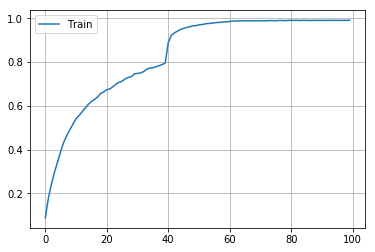

In [18]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

In [ ]:
#сохранение модели на диск
with open('model3', 'w'):
    torch.save(resnet, 'model3')

In [117]:
#загрузка модели с диска
resnet2 = torch.load('model3')

In [133]:
my_solution = make_solution(resnet2, DEVICE2)
with open('solution2.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)